# ARIN7102 Applied Datamining and Text Analytics: Assignment 1

## Question 4: K-Nearest Neighbors (kNN)

In this section you will implement a K-Nearest Neighbors (kNN) classifier on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Recall that the K-Nearest Neighbor classifier is a non-parametric, supervised learning classifier, which use proxomity to make classifications or predictions about the grouping of an individual data point. A class label is assigned on the basis of a majority vote i.e., the label that is most frequently represented around a given data point is used.

After implementing the K-Nearest Neighbor classifier, you will use *cross-validation* to find the best value of K.

The goals of this section are to go through a simple example of the data-driven image classification pipeline, and also to practice writing efficient, vectorized code in [PyTorch](https://pytorch.org/) as most likely you will use this framework for your final project. All the best!

In this section there are 6 functions / classes that you are required to fill in i.e.:

- [  ] [Task] compute_distances_two_loops (3 points)
- [  ] [Task] compute_distances_one_loop (3 points)
- [  ] [Task] compute_distances_no_loops (3 points)
- [  ] [Task] predict_labels (3 points)
- [  ] [Task] KnnClassifier (6 points)
- [  ] [Task] knn_cross_validate (6 points)

* In case, if you find it hard to keep track your progress, you can also use the checkbox to track which function you have completed ([  ] / [ x ]).

* You are not allowed to import other extra libraries in this section

#### 1. Data preprocessing and Visualization

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import statistics

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

#### 2. Load the CIFAR-10 dataset
from Torchvision library, function `datasets.CIFAR10` returns the entire CIFAR-10 dataset:

- `x_train` contains all training images (real numbers in the range $[0, 255]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `x_test` contains all test images
- `y_test` contains all test labels

This function automatically downloads the CIFAR-10 dataset the first time you run it.

In [7]:
import torchvision.datasets as datasets
cifar_trainset = datasets.CIFAR10(root='./dataset', train=True, download=True, transform=None)
cifar_testset = datasets.CIFAR10(root='./dataset', train=False, download=True, transform=None)

x_train_ori = torch.tensor(cifar_trainset.data) / 255
x_test_ori = torch.tensor(cifar_testset.data) / 255
y_train_ori = torch.tensor(cifar_trainset.targets)
y_test_ori = torch.tensor(cifar_testset.targets)

print('Training set:', )
print('  data shape:', x_train_ori.shape)
print('  labels shape: ', y_train_ori.shape)
print('Test set:')
print('  data shape: ', x_test_ori.shape)
print('  labels shape', y_test_ori.shape)

Files already downloaded and verified
Files already downloaded and verified
Training set:
  data shape: torch.Size([50000, 32, 32, 3])
  labels shape:  torch.Size([50000])
Test set:
  data shape:  torch.Size([10000, 32, 32, 3])
  labels shape torch.Size([10000])


#### 3. Visualize the dataset
To give you a sense of the nature of the images in CIFAR-10, this cell visualizes some random examples from the training set.

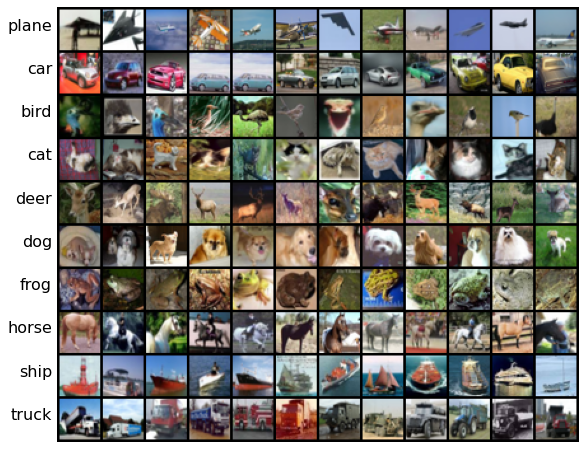

In [8]:
import random
from torchvision.utils import make_grid


classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 12
samples = []
for y, cls in enumerate(classes):
    plt.text(-4, 34 * y + 18, cls, ha='right')
    idxs, = np.where(y_train_ori == y)
    for i in range(samples_per_class):
        idx = idxs[random.randrange(idxs.shape[0])].item()
        x_train_idx = torch.Tensor(x_train_ori[idx])
        x_train_idx = x_train_idx.swapaxes(0,2)
        x_train_idx = x_train_idx.swapaxes(1,2)
        samples.append(x_train_idx)

img = make_grid(samples, nrow=samples_per_class)
plt.imshow(img.permute(1,2,0))
plt.axis('off')
plt.show()

#### 4.  Subsample the dataset
When implementing machine learning algorithms, it's usually a good idea to use a small sample of the full dataset. This way your code will run much faster, allowing for more interactive and efficient development. Once you are satisfied that you have correctly implemented the algorithm, you can then rerun with the entire dataset.

We will subsample the data to use only 500 training examples and 250 test examples:

In [9]:
def subsample_dataset(x_train, y_train, x_test, y_test, num_train=None, num_test=None):

    if num_train != None:
        x_train = x_train[:num_train]
        y_train = y_train[:num_train]
        
    if num_test != None:
        x_test = x_test[:num_test]
        y_test = y_test[:num_test]

    return x_train, y_train, x_test, y_test

In [10]:
num_train = 500
num_test = 250

x_train, y_train, x_test, y_test = subsample_dataset(x_train_ori, y_train_ori, x_test_ori, y_test_ori, num_train, num_test)

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Test set:')
print('  data shape: ', x_test.shape)
print('  labels shape', y_test.shape)

Training set:
  data shape: torch.Size([500, 32, 32, 3])
  labels shape:  torch.Size([500])
Test set:
  data shape:  torch.Size([250, 32, 32, 3])
  labels shape torch.Size([250])


#### 5. K-Nearest Neighbors (k-NN)

#### [Task] Compute distances: Naive implementation
Now that we have examined and prepared our data, it is time to implement the kNN classifier. We can break the process down into two steps:

1. By using a distance metric such as Euclidan distance, calculate the distance between the query point (test data) and the other data points (training data).
2. Given these distances calculated from the first step, for each test example, find its k nearest neigbours and find the predicted label by having a vote mechanism.

Lets begin with computing the distance matrix between all training and test examples. First we will implement a naive version of the distance computation, using explicit loops over the training and test sets. Implement the function `compute_distances_two_loops`! Before implementing the function, it is recommended to read the function description and NOTE inside the function. Moreover, you can only write your code in the predefined place. 

In [17]:
def compute_distances_two_loops(x_train, x_test):
    """
    Computes the squared Euclidean distance between each element of training
    set and each element of test set. Images should be flattened and treated
    as vectors.

    This implementation uses a naive set of nested loops over the training and
    test data.

    The input data may have any number of dimensions -- for example this
    function should be able to compute nearest neighbor between vectors, in
    which case the inputs will have shape (num_{train, test}, D); it should
    also be able to compute nearest neighbors between images, where the inputs
    will have shape (num_{train, test}, C, H, W). More generally, the inputs
    will have shape (num_{train, test}, D1, D2, ..., Dn); you should flatten
    each element of shape (D1, D2, ..., Dn) into a vector of shape
    (D1 * D2 * ... * Dn) before computing distances.

    The input tensors should not be modified.

    NOTE: Your implementation may not use `torch.norm`, `torch.dist`,
    `torch.cdist`, or their instance method variants (`x.norm`, `x.dist`,
    `x.cdist`, etc.). You may not use any functions from `torch.nn` or
    `torch.nn.functional` modules.

    Args:
        x_train: Tensor of shape (num_train, D1, D2, ...)
        x_test: Tensor of shape (num_test, D1, D2, ...)

    Returns:
        dists: Tensor of shape (num_train, num_test) where dists[i, j]
            is the squared Euclidean distance between the i-th training point
            and the j-th test point. It should have the same dtype as x_train.
    """
    # Initialize dists to be a tensor of shape (num_train, num_test) with the
    # same datatype and device as x_train
    num_train = x_train.shape[0]
    num_test = x_test.shape[0]
    dists = x_train.new_zeros(num_train, num_test)
    ##########################################################################
    # TODO: Implement this function using a pair of nested loops over the    #
    # training data and the test data.                                       #
    #                                                                        #
    # You may not use torch.norm (or its instance method variant), nor any   #
    # functions from torch.nn or torch.nn.functional.                        #
    ##########################################################################
    # Replace "pass" statement with your code
    
    x_train_flat = x_train.reshape(num_train, -1)  # (num_train, D)
    x_test_flat = x_test.reshape(num_test, -1)    # (num_test, D)

    for i in range(num_train):
        for j in range(num_test):
            # Euclidean distance
            diff = x_train_flat[i] - x_test_flat[j]
            dists[i, j] = torch.sum(diff ** 2)


    ##########################################################################
    #                           END OF YOUR CODE                             #
    ##########################################################################
    return dists

In [18]:
torch.manual_seed(0)

dists = compute_distances_two_loops(x_train, x_test)
print('dists has shape: ', dists.shape)

dists has shape:  torch.Size([500, 250])


As a visual debugging step, we can visualize the distance matrix, where each row is a test example and each column is a training example.

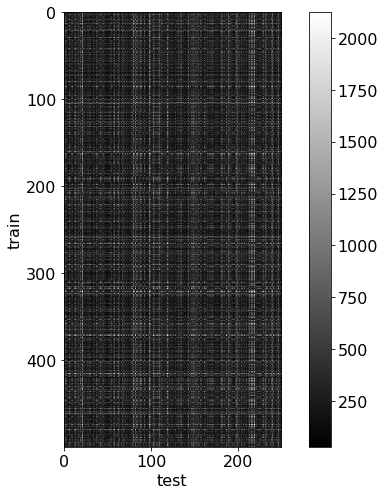

In [19]:
plt.imshow(dists.numpy(), cmap='gray', interpolation='none')
plt.colorbar()
plt.xlabel('test')
plt.ylabel('train')
plt.show()

#### [Task] Compute distances: Vectorization
Our implementation of the distance computation above is fairly inefficient since it uses nested Python loops over the training and test sets.

When implementing algorithms in PyTorch, it's best to avoid loops in Python if possible. Instead it is preferable to implement your computation so that all loops happen inside PyTorch functions. This will usually be much faster than writing your own loops in Python, since PyTorch functions can be internally optimized to iterate efficiently, possibly using multiple threads. This is especially important when using a GPU to accelerate your code.

The process of eliminating explict loops from your code is called **vectorization**. Sometimes it is straighforward to vectorize code originally written with loops; other times vectorizing requires thinking about the problem in a new way. We will use vectorization to improve the speed of our distance computation function.

As a first step toward vectorizing our distance computation, you will implement a version that uses only a single Python loop over the training data. Complete the implementation of the function `compute_distances_one_loop`! Before implementing the function, it is recommended to read the function description and NOTE inside the function. Moreover, you can only write your code in the predefined place. 

We can check the correctness of our one-loop implementation by comparing it with our two-loop implementation on some randomly generated data.

Note that we do the comparison with 64-bit floating points for increased numeric precision.

In [24]:
def compute_distances_one_loop(x_train, x_test):
    """
    Computes the squared Euclidean distance between each element of training
    set and each element of test set. Images should be flattened and treated
    as vectors.

    This implementation uses only a single loop over the training data.

    Similar to `compute_distances_two_loops`, this should be able to handle
    inputs with any number of dimensions. The inputs should not be modified.

    NOTE: Your implementation may not use `torch.norm`, `torch.dist`,
    `torch.cdist`, or their instance method variants (`x.norm`, `x.dist`,
    `x.cdist`, etc.). You may not use any functions from `torch.nn` or
    `torch.nn.functional` modules.

    Args:
        x_train: Tensor of shape (num_train, D1, D2, ...)
        x_test: Tensor of shape (num_test, D1, D2, ...)

    Returns:
        dists: Tensor of shape (num_train, num_test) where dists[i, j]
            is the squared Euclidean distance between the i-th training point
            and the j-th test point. It should have the same dtype as x_train.
    """
    # Initialize dists to be a tensor of shape (num_train, num_test) with the
    # same datatype and device as x_train
    num_train = x_train.shape[0]
    num_test = x_test.shape[0]
    dists = x_train.new_zeros(num_train, num_test)
    ##########################################################################
    # TODO: Implement this function using only a single loop over x_train.   #
    #                                                                        #
    # You may not use torch.norm (or its instance method variant), nor any   #
    # functions from torch.nn or torch.nn.functional.                        #
    ##########################################################################
    # Replace "pass" statement with your code
    x_train_flat = x_train.reshape(num_train, -1)  # (num_train, D)
    x_test_flat = x_test.reshape(num_test, -1)    # (num_test, D)
    
    for i in range(num_train):
        diff = x_train_flat[i] - x_test_flat
        dists[i] = torch.sum(diff ** 2, dim=1)
    ##########################################################################
    #                           END OF YOUR CODE                             #
    ##########################################################################
    return dists

In [25]:
torch.manual_seed(0)
x_train_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)

dists_one = compute_distances_one_loop(x_train_rand, x_test_rand)
dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)
difference = (dists_one - dists_two).pow(2).sum().sqrt().item()
print('Difference: ', difference)
if difference < 1e-4:
    print('Good! The distance matrices match')
else:
    print('Uh-oh! The distance matrices are different')

Difference:  0.0
Good! The distance matrices match


You will now implement a fully vectorized version of the distance computation function
that does not use any Python loops. Implement the function `compute_distances_no_loops`. Before implementing the function, it is recommended to read the function description and NOTE inside the function. Moreover, you can only write your code in the predefined place.

As before, we can check the correctness of our implementation by comparing the fully vectorized version against the original naive version:

In [52]:
def compute_distances_no_loops(x_train: torch.Tensor, x_test: torch.Tensor):
    """
    Computes the squared Euclidean distance between each element of training
    set and each element of test set. Images should be flattened and treated
    as vectors.

    This implementation should not use any Python loops. For memory-efficiency,
    it also should not create any large intermediate tensors; in particular you
    should not create any intermediate tensors with O(num_train * num_test)
    elements.

    Similar to `compute_distances_two_loops`, this should be able to handle
    inputs with any number of dimensions. The inputs should not be modified.

    NOTE: Your implementation may not use `torch.norm`, `torch.dist`,
    `torch.cdist`, or their instance method variants (`x.norm`, `x.dist`,
    `x.cdist`, etc.). You may not use any functions from `torch.nn` or
    `torch.nn.functional` modules.

    Args:
        x_train: Tensor of shape (num_train, C, H, W)
        x_test: Tensor of shape (num_test, C, H, W)

    Returns:
        dists: Tensor of shape (num_train, num_test) where dists[i, j] is
            the squared Euclidean distance between the i-th training point and
            the j-th test point.
    """
    # Initialize dists to be a tensor of shape (num_train, num_test) with the
    # same datatype and device as x_train
    num_train = x_train.shape[0]
    num_test = x_test.shape[0]
    dists = x_train.new_zeros(num_train, num_test)
    ##########################################################################
    # TODO: Implement this function without using any explicit loops and     #
    # without creating any intermediate tensors with O(num_train * num_test) #
    # elements.                                                              #
    #                                                                        #
    # You may not use torch.norm (or its instance method variant), nor any   #
    # functions from torch.nn or torch.nn.functional.                        #
    #                                                                        #
    # HINT: Try to formulate the Euclidean distance using two broadcast sums #
    # and a matrix multiply.                                                 # 
    ##########################################################################   
    '''
    Reference:
    https://stackoverflow.com/questions/27948363/numpy-broadcast-to-perform-euclidean-distance-vectorized                                       #
    '''
    # Replace "pass" statement with your code
    x_train_flat = x_train.reshape(num_train, -1)
    x_test_flat = x_test.reshape(num_test, -1)

    dists = (
        torch.sum(x_train_flat ** 2, dim=1, keepdim=True)
        - 2 * torch.mm(x_train_flat, x_test_flat.T)
        + torch.sum(x_test_flat ** 2, dim=1, keepdim=True).T
    )

    dists = dists.clamp(min=0)
    ##########################################################################
    #                           END OF YOUR CODE                             #
    ##########################################################################
    return dists

In [53]:
torch.manual_seed(0)
x_train_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)
x_test_rand = torch.randn(100, 3, 16, 16, dtype=torch.float64)

dists_two = compute_distances_two_loops(x_train_rand, x_test_rand)
dists_none = compute_distances_no_loops(x_train_rand, x_test_rand)
difference = (dists_two - dists_none).pow(2).sum().sqrt().item()
print('Difference: ', difference)
if difference < 1e-4:
  print('Good! The distance matrices match')
else:
  print('The distance matrices are different, please check your implementation again!')

Difference:  1.7875967397231723e-11
Good! The distance matrices match


We can now compare the speed of our three implementations. If you've implemented everything properly, the one-loop implementation should take less than 4 seconds to run, and the fully vectorized implementation should take less than 0.1 seconds to run.

In [54]:
import time

def timeit(f, *args):
    tic = time.time()
    f(*args) 
    toc = time.time()
    return toc - tic

torch.manual_seed(0)
x_train_rand = torch.randn(500, 3, 32, 32)
x_test_rand = torch.randn(500, 3, 32, 32)

two_loop_time = timeit(compute_distances_two_loops, x_train_rand, x_test_rand)
print('Two loop version took %.2f seconds' % two_loop_time)

one_loop_time = timeit(compute_distances_one_loop, x_train_rand, x_test_rand)
speedup = two_loop_time / one_loop_time
print('One loop version took %.2f seconds (%.1fX speedup)'
      % (one_loop_time, speedup))

no_loop_time = timeit(compute_distances_no_loops, x_train_rand, x_test_rand)
speedup = two_loop_time / no_loop_time
print('No loop version took %.2f seconds (%.1fX speedup)'
      % (no_loop_time, speedup))

Two loop version took 12.02 seconds
One loop version took 2.59 seconds (4.6X speedup)
No loop version took 0.02 seconds (706.8X speedup)


#### [Task] Predict labels
Now that we have a method for computing distances between training and test examples, we need to implement a function that uses those distances together with the training labels to predict labels for test samples.

Implement the function `predict_labels`. Before implementing the function, it is recommended to read the function description and NOTE inside the function. Moreover, you can only write your code in the predefined place. 

In [55]:
def predict_labels(dists, y_train, k=1):
  """
  Given distances between all pairs of training and test samples, predict a
  label for each test sample by taking a **majority vote** among its k nearest
  neighbors in the training set.
  In the event of a tie, this function **should** return the smallest label. For
  example, if k=5 and the 5 nearest neighbors to a test example have labels
  [1, 2, 1, 2, 3] then there is a tie between 1 and 2 (each have 2 votes), so
  we should return 1 since it is the smallest label.
s
  This function should not modify any of its inputs.
  Inputs:
  - dists: Torch tensor of shape (num_train, num_test) where dists[i, j] is the
    squared Euclidean distance between the ith training point and the jth test
    point.
  - y_train: Torch tensor of shape (num_train,) giving labels for all training
    samples. Each label is an integer in the range [0, num_classes - 1]
  - k: The number of nearest neighbors to use for classification.
  Returns:
  - y_pred: A torch int64 tensor of shape (num_test,) giving predicted labels
    for the test data, where y_pred[j] is the predicted label for the jth test
    example. Each label should be an integer in the range [0, num_classes - 1].
  """
  num_train, num_test = dists.shape
  y_pred = torch.zeros(num_test, dtype=torch.int64)
  ##############################################################################
  # TODO: Implement this function. You may use an explicit loop over the test  #
  # samples. Hint: Look up the function torch.topk                             #
  ##############################################################################
  # Replace "pass" statement with your code
  
  for j in range(num_test):
        
        distances, indices = torch.topk(dists[:, j], k=k, largest=False)
        
        # Obtain the k nearest neighbors' labels
        k_nearest_labels = y_train[indices]
        
        label_counts = torch.bincount(k_nearest_labels)
        y_pred[j] = torch.argmax(label_counts)
  
  ##############################################################################
  #                             END OF YOUR CODE                               #
  ##############################################################################
  return y_pred

In [56]:
torch.manual_seed(0)
dists = torch.tensor([
    [0.3, 0.4, 0.1],
    [0.1, 0.5, 0.5],
    [0.4, 0.1, 0.2],
    [0.2, 0.2, 0.4],
    [0.5, 0.3, 0.3],
])
y_train_ = torch.tensor([0, 1, 0, 1, 2])
y_pred_expected = torch.tensor([1, 0, 0])
y_pred_ = predict_labels(dists, y_train_, k=3)
correct_ = y_pred_.tolist() == y_pred_expected.tolist()
print('Correct: ', correct_)

Correct:  True


Now we have implemented all the required functionality for the K-Nearest Neighbor classifier. Complete the implementation of the `KnnClassifer` class. Before implementing the function, it is recommended to read the function description and NOTE inside the function. Moreover, you can only write your code in the predefined place. 

We can get some intuition into the KNN classifier by visualizing its predictions on toy 2D data. Here we will generate some random training and test points in 2D, and assign random labels to the training points. We can then make predictions for the test points, and visualize both training and test points. Training points are shown as stars, and tet points are shown as small transparent circles. The color of each point denots its label -- ground-truth label for training points, and predicted label for test points.

In [57]:
class KnnClassifier:
  def __init__(self, x_train, y_train):
    """
    Create a new K-Nearest Neighbor classifier with the specified training data.
    In the initializer we simply memorize the provided training data.
    Inputs:
    - x_train: Torch tensor of shape (num_train, C, H, W) giving training data
    - y_train: int64 torch tensor of shape (num_train,) giving training labels
    """
    ###########################################################################
    # TODO: Implement the initializer for this class. It should perform no    #
    # computation and simply memorize the training data.                      #
    ###########################################################################
    # Replace "pass" statement with your code
    self.x_train = x_train
    self.y_train = y_train
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################

  def predict(self, x_test, k=1):
    """
    Make predictions using the classifier.
    Inputs:
    - x_test: Torch tensor of shape (num_test, C, H, W) giving test samples
    - k: The number of neighbors to use for predictions
    Returns:
    - y_test_pred: Torch tensor of shape (num_test,) giving predicted labels
      for the test samples.
    """
    y_test_pred = None
    ###########################################################################
    # TODO: Implement this method. You should use the functions you wrote     #
    # above for computing distances (use the no-loop variant) and to predict  #
    # output labels.
    ###########################################################################
    # Replace "pass" statement with your code
    dists = compute_distances_no_loops(self.x_train, x_test)
    y_test_pred = predict_labels(dists, self.y_train, k)
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_test_pred

  def check_accuracy(self, x_test, y_test, k=1, quiet=False):
    """
    Utility method for checking the accuracy of this classifier on test data.
    Returns the accuracy of the classifier on the test data, and also prints a
    message giving the accuracy.
    Inputs:
    - x_test: Torch tensor of shape (num_test, C, H, W) giving test samples
    - y_test: int64 torch tensor of shape (num_test,) giving test labels
    - k: The number of neighbors to use for prediction
    - quiet: If True, don't print a message.
    Returns:
    - accuracy: Accuracy of this classifier on the test data, as a percent.
      Python float in the range [0, 100]
    """
    y_test_pred = self.predict(x_test, k=k)
    num_samples = x_test.shape[0]
    num_correct = (y_test == y_test_pred).sum().item()
    accuracy = 100.0 * num_correct / num_samples
    msg = (f'Got {num_correct} / {num_samples} correct; '
           f'accuracy is {accuracy:.2f}%')
    if not quiet:
      print(msg)
    return accuracy

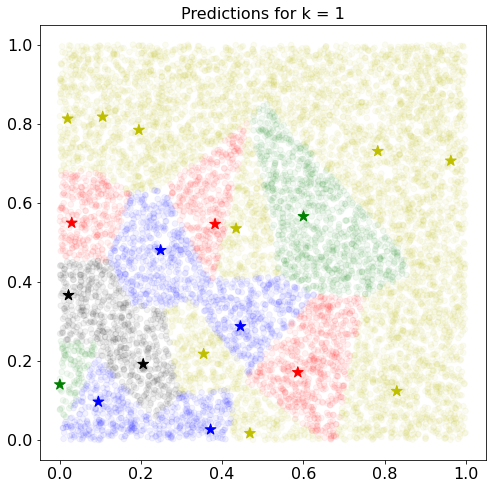

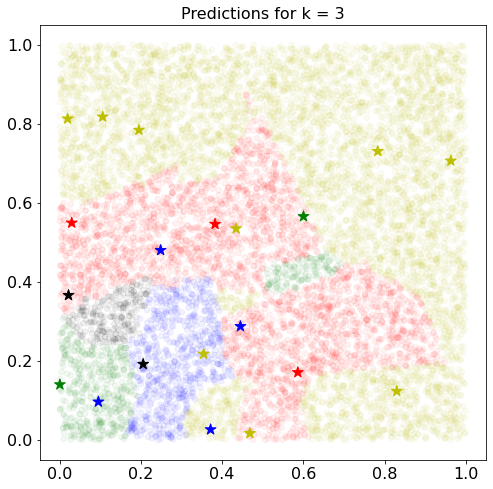

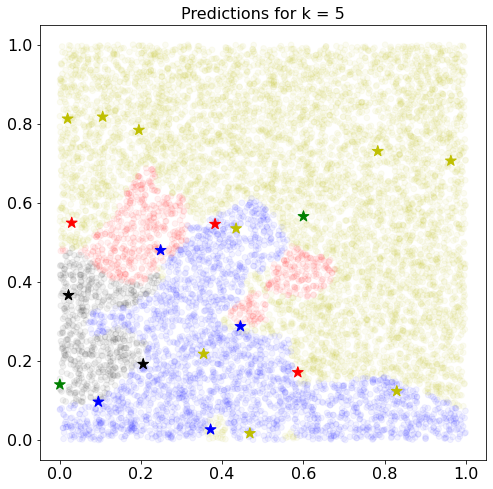

In [58]:
num_test = 10000
num_train = 20
num_classes = 5

# Generate random training and test data
torch.manual_seed(17)
x_train_rand = torch.rand(num_train, 2)
y_train_rand = torch.randint(num_classes, size=(num_train,))
x_test_rand = torch.rand(num_test, 2)
classifier = KnnClassifier(x_train_rand, y_train_rand)

# Plot predictions for different values of k
for k in [1, 3, 5]:
    y_test_rand = classifier.predict(x_test_rand, k=k)
    plt.gcf().set_size_inches(8, 8)
    class_colors = ['r', 'g', 'b', 'k', 'y']
    train_colors = [class_colors[c] for c in y_train_rand]
    test_colors = [class_colors[c] for c in y_test_rand]
    plt.scatter(x_test_rand[:, 0], x_test_rand[:, 1],
                color=test_colors, marker='o', s=32, alpha=0.05)
    plt.scatter(x_train_rand[:, 0], x_train_rand[:, 1],
                color=train_colors, marker='*', s=128.0)
    plt.title('Predictions for k = %d' % k, size=16)
    plt.show()

We can use the exact same KNN code to perform image classification on CIFAR-10!

Now lets put everything together and test our K-NN clasifier on a subset of CIFAR-10, using k=1:

If you've implemented everything correctly you should see an accuracy of about 27%.

In [59]:
torch.manual_seed(0)
num_train = 5000
num_test = 500
x_train, y_train, x_test, y_test = subsample_dataset(x_train_ori, y_train_ori, x_test_ori, y_test_ori, num_train, num_test)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=1)

Got 137 / 500 correct; accuracy is 27.40%


27.4

Now lets increase to k=5. You should see a slightly higher accuracy than k=1:

In [61]:
torch.manual_seed(0)
num_train = 5000
num_test = 500
x_train, y_train, x_test, y_test = subsample_dataset(x_train_ori, y_train_ori, x_test_ori, y_test_ori, num_train, num_test)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=5)

Got 139 / 500 correct; accuracy is 27.80%


27.8

#### [Task] Cross-validation
We have not implemented the full k-Nearest Neighbor classifier, but the choice of $k=5$ was arbitrary. We will use **cross-validation** to set this hyperparameter in a more principled manner.

Implement the function `knn_cross_validate` to perform cross-validation on k. Before implementing the function, it is recommended to read the function description and NOTE inside the function. Moreover, you can only write your code in the predefined place. 

In [67]:
def knn_cross_validate(x_train, y_train, num_folds=5, k_choices=None):
    """
    Perform cross-validation for KnnClassifier.
    Inputs:
    - x_train: Tensor of shape (num_train, C, H, W) giving all training data
    - y_train: int64 tensor of shape (num_train,) giving labels for training data
    - num_folds: Integer giving the number of folds to use
    - k_choices: List of integers giving the values of k to try
    Returns:
    - k_to_accuracies: Dictionary mapping values of k to lists, where
      k_to_accuracies[k][i] is the accuracy on the ith fold of a KnnClassifier
      that uses k nearest neighbors.
    """
    if k_choices is None:
        # Use default values, do not change
        k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

    # First we divide the training data into num_folds equally-sized folds.
    x_train_folds = []
    y_train_folds = []
    ##############################################################################
    # TODO: Split the training data and images into folds. After splitting,      #
    # x_train_folds and y_train_folds should be lists of length num_folds, where #
    # y_train_folds[i] is the label vector for images in x_train_folds[i].       #
    # Hint: torch.chunk                                                          #
    ##############################################################################
    # Replace "pass" statement with your code
    x_train_folds = list(torch.chunk(x_train, num_folds))
    y_train_folds = list(torch.chunk(y_train, num_folds))

    ##############################################################################
    #                            END OF YOUR CODE                                #
    ##############################################################################

    # A dictionary holding the accuracies for different values of k that we find
    # when running cross-validation. After running cross-validation,
    # k_to_accuracies[k] should be a list of length num_folds giving the different
    # accuracies we found when trying KnnClassifiers that use k neighbors.
    k_to_accuracies = {}

    ##############################################################################
    # TODO: Perform cross-validation to find the best value of k. For each value #
    # of k in k_choices, run the k-nearest-neighbor algorithm num_folds times;   #
    # in each case you'll use all but one fold as training data, and use the     #
    # last fold as a validation set. Store the accuracies for all folds and all  #
    # values in k in k_to_accuracies.   HINT: torch.cat                          #
    ##############################################################################
    # Replace "pass" statement with your code
    
    for k in k_choices:
        for fold in range(num_folds):
            x_val = x_train_folds[fold]
            y_val = y_train_folds[fold]

            x_train_fold = torch.cat([x_train_folds[i] for i in range(num_folds) if i != fold])
            y_train_fold = torch.cat([y_train_folds[i] for i in range(num_folds) if i != fold])

            classifier = KnnClassifier(x_train_fold, y_train_fold)  # Assume KnnClassifier is defined elsewhere
            y_pred = classifier.predict(x_val, k=k)

            accuracy = (y_pred == y_val).float().mean().item()
            if k not in k_to_accuracies:
                k_to_accuracies[k] = [accuracy]
            else:
                k_to_accuracies[k].append(accuracy)

    ##############################################################################
    #                            END OF YOUR CODE                                #
    ##############################################################################

    return k_to_accuracies


In [68]:
torch.manual_seed(0)
num_train = 5000
num_test = 500
x_train, y_train, x_test, y_test = subsample_dataset(x_train_ori, y_train_ori, x_test_ori, y_test_ori, num_train, num_test)

k_to_accuracies = knn_cross_validate(x_train, y_train, num_folds=5)

for k, accs in sorted(k_to_accuracies.items()):
  print('k = %d got accuracies: %r' % (k, accs))

k = 1 got accuracies: [0.2630000114440918, 0.25699999928474426, 0.2639999985694885, 0.27799999713897705, 0.26600000262260437]
k = 3 got accuracies: [0.23899999260902405, 0.24899999797344208, 0.23999999463558197, 0.26600000262260437, 0.2540000081062317]
k = 5 got accuracies: [0.24799999594688416, 0.26600000262260437, 0.2800000011920929, 0.2919999957084656, 0.2800000011920929]
k = 8 got accuracies: [0.2619999945163727, 0.28200000524520874, 0.27300000190734863, 0.28999999165534973, 0.27300000190734863]
k = 10 got accuracies: [0.26499998569488525, 0.29600000381469727, 0.2759999930858612, 0.2840000092983246, 0.2800000011920929]
k = 12 got accuracies: [0.25999999046325684, 0.29499998688697815, 0.27900001406669617, 0.28299999237060547, 0.2800000011920929]
k = 15 got accuracies: [0.25200000405311584, 0.289000004529953, 0.27799999713897705, 0.28200000524520874, 0.27399998903274536]
k = 20 got accuracies: [0.27000001072883606, 0.27900001406669617, 0.27900001406669617, 0.28200000524520874, 0.2849

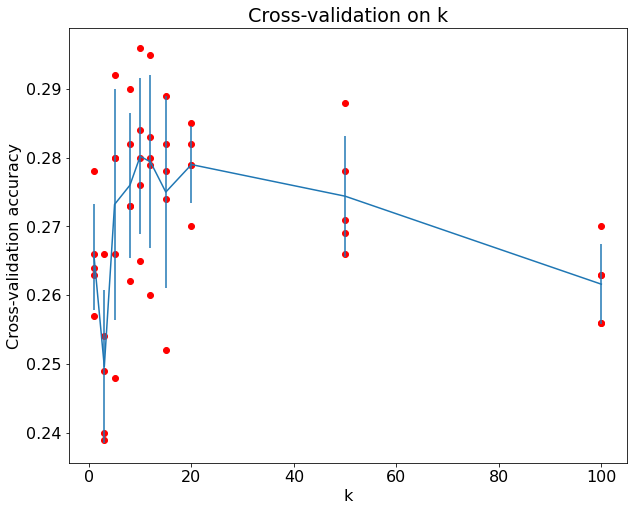

In [69]:
ks, means, stds = [], [], []
torch.manual_seed(0)
for k, accs in sorted(k_to_accuracies.items()):
  plt.scatter([k] * len(accs), accs, color='r')
  ks.append(k)
  means.append(statistics.mean(accs))
  stds.append(statistics.stdev(accs))
plt.errorbar(ks, means, yerr=stds)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.title('Cross-validation on k')
plt.show()

Now we can use the results of cross-validation to select the best value for k, and rerun the classifier on our full 5000 set of training examples.

You should get an accuracy above 28%.

In [70]:
def knn_get_best_k(k_to_accuracies):
  best_k = 0
  new_dict = {}
  for k, accs in sorted(k_to_accuracies.items()):
     new_dict[k] = sum(accs) / len(accs) 
  max_value = max(new_dict.values())
  best_k = [k for k, v in new_dict.items() if v == max_value][0]
  return best_k

In [71]:
best_k = 1
torch.manual_seed(0)

best_k = knn_get_best_k(k_to_accuracies)    
print('Best k is ', best_k)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=best_k)

Best k is  10
Got 141 / 500 correct; accuracy is 28.20%


28.2

Finally, we can use our chosen value of k to run on the entire training and test sets.

This may take a while to run, since the full training and test sets have 50k and 10k examples respectively. You should get an accuracy above 33%.

**Run this only once!**

In [72]:
torch.manual_seed(0)
x_train_all, y_train_all, x_test_all, y_test_all = subsample_dataset(x_train_ori, y_train_ori, x_test_ori, y_test_ori)
classifier = KnnClassifier(x_train_all, y_train_all)
classifier.check_accuracy(x_test_all, y_test_all, k=best_k)

Got 3386 / 10000 correct; accuracy is 33.86%


33.86

That's all for the k-NN questions, you can proceed to the next section!